In [235]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [236]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False)

In [237]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing across the sky &amp; making 90 degree turns on a dime.,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 England,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10


In [238]:
# limita o df aos USA

df_us = df.loc[df['country'] == 'us']
df_us.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10
5,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl with us now 51 myself 49 and the other fellow which worked with my father...,36.595000,-82.188889,1961-10-10
7,norwalk,ct,us,disk,20.000000,A bright orange color changing to reddish color disk/saucer was observed hovering above power transmission lines.,41.117500,-73.408333,1965-10-10


In [239]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df_us[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

70290
[[ -97.9411111   29.8830556]
 [ -96.6458333   28.9783333]
 [-157.8036111   21.4180556]
 ...
 [ -97.4777778   35.6527778]
 [ -82.6958333   34.3769444]
 [ -80.1436111   26.1219444]]


In [240]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df_us['state'])
pesos = [states.count(s) for s in states]

In [241]:
scaler = MinMaxScaler()

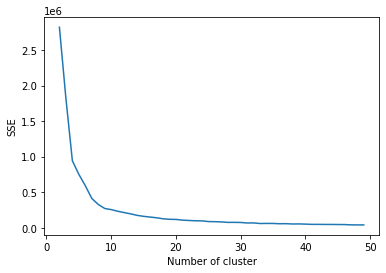

In [242]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### De acordo com o Elbow Criteria o número adequado de clusters é em torno de 12

In [147]:
# aplica o coeficiente de silhouette

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon))
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=2, o coeficiente de  Silhouette 0.5441298545078485
Para n_clusters=3, o coeficiente de  Silhouette 0.4761917747180368
Para n_clusters=4, o coeficiente de  Silhouette 0.5012828136406076
Para n_clusters=5, o coeficiente de  Silhouette 0.47988372382855976
Para n_clusters=6, o coeficiente de  Silhouette 0.47325465100474756
Para n_clusters=7, o coeficiente de  Silhouette 0.49190725664290885
Para n_clusters=8, o coeficiente de  Silhouette 0.5088311677452116
Para n_clusters=9, o coeficiente de  Silhouette 0.5144083381090238
Para n_clusters=10, o coeficiente de  Silhouette 0.5225164235096935
Para n_clusters=11, o coeficiente de  Silhouette 0.5271327754616774
Para n_clusters=12, o coeficiente de  Silhouette 0.5290019873920169
Para n_clusters=13, o coeficiente de  Silhouette 0.5251137329334027
Para n_clusters=14, o coeficiente de  Silhouette 0.5057740202243741
Para n_clusters=15, o coeficiente de  Silhouette 0.4984355637534651
Para n_clusters=16, o coeficiente de  Silhouette 0.49

### De acordo com o Score Silhouette o número adequado de clusters é em torno de 12

In [243]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=12, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.71027257, 0.22622871],
       [0.72196002, 0.20905126],
       [0.17012595, 0.06550849],
       ...,
       [0.71445329, 0.3357752 ],
       [0.84783257, 0.31155167],
       [0.87086158, 0.1548186 ]])

In [244]:
centers = kmeans.cluster_centers_
centers

array([[0.71632644, 0.24902393],
       [0.53644424, 0.30206383],
       [0.81434183, 0.45484946],
       [0.49601567, 0.38389771],
       [0.49607726, 0.55159565],
       [0.91464342, 0.44251644],
       [0.85619729, 0.18902382],
       [0.24874659, 0.83319218],
       [0.8591414 , 0.3289288 ],
       [0.17405701, 0.05880549],
       [0.76856845, 0.38155715],
       [0.63740492, 0.3974608 ]])

In [245]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

70290


array([ 0.,  0.,  9., ..., 10.,  8.,  6.])

Text(0, 0.5, 'Longitude')

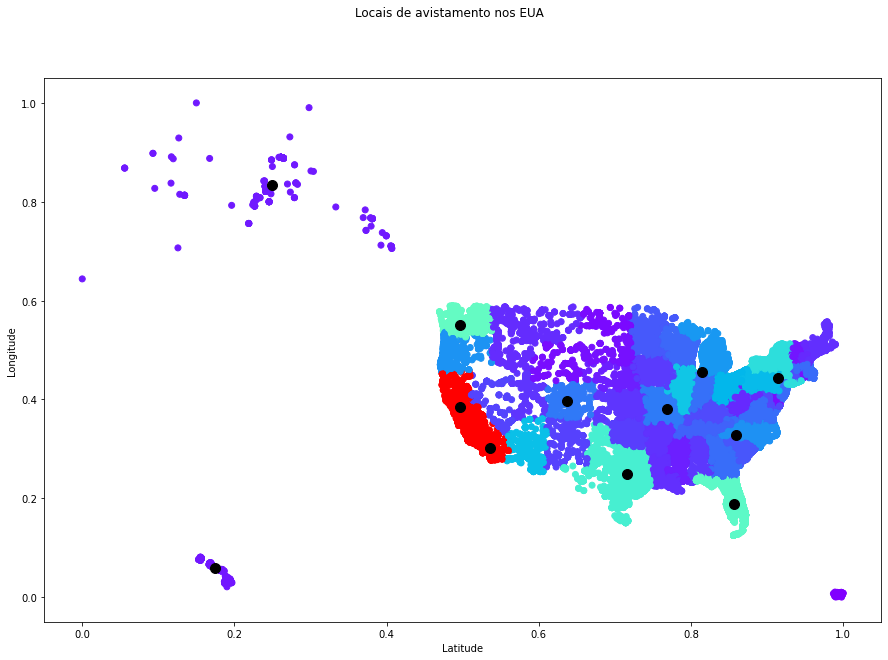

In [246]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [247]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [249]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

In [250]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

In [251]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"31.0836609047496, -97.27018303557934","(Little Flock Road, Bell County, Texas, 76501, United States, (31.080800978440074, -97.26980570585856))"
1,"33.87722778114206, -117.20587807848636","(16834, Fox Trot Lane, Moreno Valley, California, 92555, United States, (33.87699019179903, -117.20672474095082))"
2,"41.92432000751247, -86.40749172427576","(East Snow Road, Oronoko Charter Township, Berrien County, Michigan, 49101, United States, (41.923026161555484, -86...."
3,"38.18735030751319, -121.68642958271518","(Newtown, Rio Vista, Solano County, California, 94571, United States, (38.185546, -121.683133))"
4,"47.01986104190211, -121.67960437147029","(National Forest Development Road 210, Pierce County, Washington, United States, (47.017399, -121.680018))"
5,"41.27474981819629, -75.29142854329015","(Panther, Greene Township, Pike County, Pennsylvania, United States, (41.2800886, -75.2993479))"
6,"27.92350474783867, -81.7688014350088","(Gaskin Road East, Bartow, Polk County, Florida, 33839, United States, (27.927649, -81.77224))"
7,"61.85131566939392, -149.09036952757577","(Fishhook, Matanuska-Susitna, Alaska, United States, (61.7557835, -149.2406783840539))"
8,"35.29218348997077, -81.44251672839574","(199, Pine Lake Drive, Woodbridge, Cleveland County, North Carolina, 28086, United States, (35.292184, -81.442901))"
9,"21.065014078260866, -157.36794584202897","(United States, (39.7837304, -100.4458825))"


In [252]:
df_s = df_us['state'].value_counts().rename_axis('state').reset_index(name='count')
df_s.head(15)

,state,count
0,ca,9574
1,wa,4292
2,fl,4155
3,tx,3742
4,ny,3234
5,il,2698
6,az,2616
7,pa,2520
8,oh,2464
9,mi,1980
